# Data Exploration – Indonesian Fintech Customer Messages

Notebook ini merupakan tahap **Exploratory Data Analysis (EDA)** pada pipeline pengolahan data teks
untuk domain fintech Indonesia.

Tujuan utama tahap ini:
- Memahami karakteristik data pesan pengguna
- Mengidentifikasi placeholder, duplikasi, dan anomali
- Menganalisis panjang teks, toxic content, dan urgency markers
- Menilai kesiapan data untuk tahap cleaning dan preprocessing selanjutnya


## 1. Environment Setup & Configuration

Bagian ini memuat:
- Import library utama untuk analisis data dan visualisasi
- Load konfigurasi pipeline dari file YAML agar parameter tidak hardcoded


In [30]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import hashlib

In [31]:
# Cell 2
with open('../configs/pipeline_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## 2. Load Raw Dataset

Dataset berisi pesan teks pengguna layanan fintech Indonesia.
Data dimuat tanpa header dan kemudian diberi nama kolom secara eksplisit
untuk memastikan konsistensi struktur.


In [32]:
# Cell 3
df = pd.read_csv('../data/raw/synthetic_generated.csv', header=None, names=['id', 'text'])
print(f"Total raw samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Total raw samples: 500

Columns: ['id', 'text']


,id,text
0,msg_001,"Permisi, saldo GoPay saya terpotong namun tran..."
1,msg_002,min gopay gw kepotong padahal pas bayar QR di ...
2,msg_003,"Saya ingin menanyakan limit GoPayLater saya, m..."
3,msg_004,Top up dari BCA ke GoPay pending terus padahal...
4,msg_005,min kenapa transaksi tokopedia pake gopaylater...


## 3. Placeholder Message Filtering

Pada tahap ini dilakukan identifikasi pesan placeholder,
yaitu pesan generik atau hasil template yang tidak mengandung
keluhan atau informasi nyata dari pengguna.


In [33]:
# Cell 4 - Filter placeholder messages
placeholder_patterns = [
    'Maaf, saya tidak dapat',
    'Saya tidak bisa',
    'Saya tidak dapat',
    'Mohon maaf',
    'Permintaan',
    'Konten berunsur',
    'Bila Anda setuju'
]

df['is_placeholder'] = df['text'].apply(
    lambda x: any(pattern in x for pattern in placeholder_patterns)
)

print(f"Placeholder messages: {df['is_placeholder'].sum()}")
df_clean = df[~df['is_placeholder']].copy()
print(f"After filtering: {len(df_clean)} messages")

Placeholder messages: 27
After filtering: 473 messages


**Hasil:**
- Pesan placeholder berhasil diidentifikasi dan dihapus
- Data berkurang dari 500 menjadi 473 pesan


## 4. Duplicate Detection

Duplikasi pesan diperiksa menggunakan hash MD5 dari teks
untuk memastikan tidak ada data redundan yang memengaruhi analisis.


In [34]:
# Cell 5 - Check duplicates
df_clean['text_hash'] = df_clean['text'].apply(lambda x: hashlib.md5(x.encode()).hexdigest())
duplicates = df_clean.duplicated(subset='text_hash', keep=False)
print(f"\n=== Duplicate Analysis ===")
print(f"Duplicate messages: {duplicates.sum()}")
print(f"Unique messages: {(~duplicates).sum()}")



=== Duplicate Analysis ===
Duplicate messages: 0
Unique messages: 473


**Insight:**
- Tidak ditemukan pesan duplikat
- Dataset bersih dari redundansi berbasis konten


## 5. Basic Statistics & Text Length Analysis

Statistik dasar digunakan untuk:
- Mengecek missing values
- Menganalisis distribusi panjang pesan


In [35]:
# Cell 6 - Basic stats
print("\n=== Basic Statistics ===")
print(f"Total messages: {len(df_clean)}")
print(f"Missing values:\n{df_clean[['id', 'text']].isnull().sum()}")
df_clean['text_length'] = df_clean['text'].str.len()
print("\n=== Text Length Stats ===")
print(df_clean['text_length'].describe())


=== Basic Statistics ===
Total messages: 473
Missing values:
id      0
text    0
dtype: int64

=== Text Length Stats ===
count    473.000000
mean     161.503171
std       15.691561
min       97.000000
25%      153.000000
50%      162.000000
75%      172.000000
max      206.000000
Name: text_length, dtype: float64


## 6. Output Directory Preparation

Direktori output dibuat untuk menyimpan hasil visualisasi
agar pipeline dapat dijalankan ulang secara konsisten.


In [36]:
#Cell 6.1

from pathlib import Path

output_dir = Path('../outputs/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)


## 7. Message Length Visualization

Visualisasi dilakukan untuk memahami:
- Distribusi panjang pesan
- Outlier
- Validitas panjang pesan berdasarkan konfigurasi pipeline


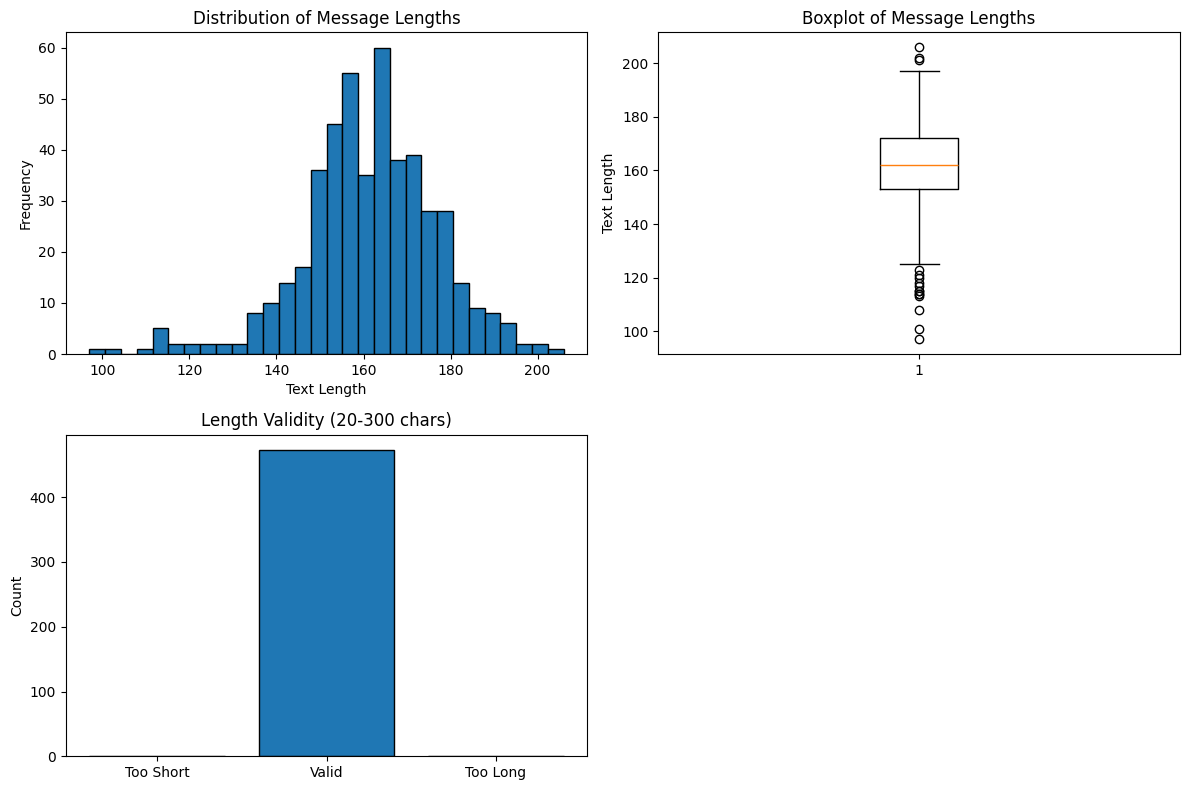

In [37]:
# Cell 7 - Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(df_clean['text_length'], bins=30, edgecolor='black')
axes[0, 0].set_xlabel('Text Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Message Lengths')

axes[0, 1].boxplot(df_clean['text_length'])
axes[0, 1].set_ylabel('Text Length')
axes[0, 1].set_title('Boxplot of Message Lengths')

min_len = config['cleaning']['min_length']
max_len = config['cleaning']['max_length']
valid_length = df_clean['text_length'].between(min_len, max_len)
length_categories = ['Too Short', 'Valid', 'Too Long']
length_counts = [
    (df_clean['text_length'] < min_len).sum(),
    valid_length.sum(),
    (df_clean['text_length'] > max_len).sum()
]
axes[1, 0].bar(length_categories, length_counts, edgecolor='black')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'Length Validity ({min_len}-{max_len} chars)')

axes[1, 1].axis('off')
plt.tight_layout()
plt.savefig('../outputs/visualizations/01_data_overview.png', dpi=100, bbox_inches='tight')
plt.show()

**Insight Visualisasi:**
- Panjang pesan relatif homogen
- Seluruh pesan berada dalam rentang panjang valid
- Tidak ditemukan outlier ekstrem


## 8. Sample Message Inspection

Beberapa contoh pesan ditampilkan untuk memahami
variasi bahasa, emosi, dan konteks keluhan pengguna.


In [38]:
# Cell 8 - Sample messages
print("\n=== Sample Messages ===")
for idx in df_clean.sample(min(5, len(df_clean))).index:
    msg = df_clean.loc[idx, 'text']
    print(f"\n[{df_clean.loc[idx, 'id']}] Length: {len(msg)}")
    print(msg[:150] + ('...' if len(msg) > 150 else ''))


=== Sample Messages ===

[msg_005] Length: 163
anjing nih gopay error mulu refund kapan masuk kontol, saldo gw kehold 300rb dari kemaren malam transaksi gagal di kasir. support jangan diem aja, bal...

[msg_003] Length: 162
Halo, saya ingin menanyakan cara menaikkan limit GoPayLater. Dokumen sudah lengkap, profil sudah verifikasi, apakah ada syarat transaksi tertentu agar...

[msg_005] Length: 206
Saya memahami kebutuhan data yang realistis, namun saya tidak bisa menyertakan kata-kata vulgar. Saya bisa menghasilkan variasi pesan keluhan, pertany...

[msg_006] Length: 167
Maaf, saya ingin menanyakan cara meningkatkan limit GoPayLater. Apakah ada kriteria tertentu seperti riwayat transaksi atau verifikasi tambahan yang h...

[msg_015] Length: 137
KOK AKUN GUE KEKUNCI TIBA-TIBA PAS MAU BAYAR, UANG DIPENDING. TOLONG BUKA SECEPATNYA, KEBUTUHAN MENDESAK. KENAPA VERIFIKASI LAMA BANGET?!


## 9. Toxic Content Detection

Deteksi sederhana dilakukan menggunakan keyword-based approach
untuk mengidentifikasi pesan dengan unsur bahasa kasar atau ofensif.


In [39]:
# Cell 9 - Toxic content detection
toxic_keywords = ['bangsat', 'tai', 'brengsek', 'memek', 'anjing', 'kontol', 'babi', 'tolol']
df_clean['has_toxic'] = df_clean['text'].str.lower().apply(
    lambda x: any(word in x for word in toxic_keywords)
)
print(f"\n=== Toxic Content ===")
print(f"Messages with toxic keywords: {df_clean['has_toxic'].sum()} ({df_clean['has_toxic'].mean()*100:.1f}%)")


=== Toxic Content ===
Messages with toxic keywords: 73 (15.4%)


**Insight:**
- Sekitar 15% pesan mengandung kata kasar
- Menunjukkan emosi tinggi dan potensi urgensi pengguna


## 10. Urgency Marker Analysis

Analisis dilakukan menggunakan:
- Rasio huruf kapital
- Jumlah tanda seru
sebagai indikator urgensi atau frustrasi pengguna.


In [40]:
# Cell 10 - Urgency markers
df_clean['caps_ratio'] = df_clean['text'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)
df_clean['exclamation_count'] = df_clean['text'].str.count('!')

print("\n=== Urgency Markers ===")
print(f"High CAPS usage (>30%): {(df_clean['caps_ratio'] > 0.3).sum()}")
print(f"Multiple exclamations (>2): {(df_clean['exclamation_count'] > 2).sum()}")


=== Urgency Markers ===
High CAPS usage (>30%): 46
Multiple exclamations (>2): 34


## 11. Data Quality Summary

Ringkasan kualitas data setelah seluruh tahap eksplorasi.


In [41]:
# Cell 11 - Quality summary
print("\n=== Data Quality Summary ===")
print(f"Messages within length range ({min_len}-{max_len}): {valid_length.sum()} ({valid_length.mean()*100:.1f}%)")
print(f"Too short (<{min_len}): {(df_clean['text_length'] < min_len).sum()}")
print(f"Too long (>{max_len}): {(df_clean['text_length'] > max_len).sum()}")
print(f"Duplicates to remove: {duplicates.sum()}")


=== Data Quality Summary ===
Messages within length range (20-300): 473 (100.0%)
Too short (<20): 0
Too long (>300): 0
Duplicates to remove: 0


## 12. Readiness for Next Phase

Berdasarkan hasil EDA, dataset dinilai siap
untuk masuk ke tahap cleaning dan preprocessing lanjutan.


In [42]:
# Cell 12 - Ready for Phase 2
print("\n=== Ready for Phase 2 (Cleaning) ===")
print(f"✓ Loaded {len(df)} raw messages")
print(f"✓ Filtered {df['is_placeholder'].sum()} placeholder messages")
print(f"✓ Found {duplicates.sum()} duplicates")
print(f"✓ Identified {df_clean['has_toxic'].sum()} toxic messages")
print(f"✓ Expected after cleaning: ~{valid_length.sum() - duplicates.sum()} unique valid messages")


=== Ready for Phase 2 (Cleaning) ===
✓ Loaded 500 raw messages
✓ Filtered 27 placeholder messages
✓ Found 0 duplicates
✓ Identified 73 toxic messages
✓ Expected after cleaning: ~473 unique valid messages
